# XCast - Probabilistic Forecast 
#### By Kyle Hall & Nachiketa Acharya 
We will use XCast Methods to create lead-1 probabilistic precipitation forecasts for August-September 2021 for the Asia Region. We will use CPC-CMAP-URD observation data as the predictand, and correspondingGCM data from COLA-RSMAS-CCSM4, CANSIPSv2, and NCEP-CFSv2 as predictors.  Since our CPC data only goes from 1982 - 2014, we will use that as the training period, and the remaining 7 years of predictors to make forecasts. 

In this section, import your modules (and xcast) and use them to load your data into Xarray DataSet/ DataArray objects.  You'll have three in the end- X_TRAIN, X_TEST, and Y_TRAIN. All of them must be 4-Dimensional, with latitude, longitude, samples, and features (in this case, samples are years , and features are models). X_TRAIN and Y_TRAIN must be the same length along the sample dimension, and Y_TRAIN must be only length 1 in the feature dimension. 

When you pass these objects to XCast, you'll need to specify the names of each of these dimensions, so it knows what to do with what. the defaults are x_sample_dim="T", x_feature_dim="M", x_lat_dim="Y", and x_lon_dim="X". Anything that differs from that needs to be specified. (For both dimensions on X and Y, in case there's a Y. those will be y_lat_dim, etc). 

In [1]:
import src as xc 
import xarray as xr 
import matplotlib.pyplot as plt 

obs = xr.open_dataset('test_data/cpc_jaso_asia_full.nc', decode_times=False)
cola = xr.open_dataset('test_data/cola_jaso_asia_full.nc', decode_times=False)
cansipsv2 = xr.open_dataset('test_data/cansipsv2_jaso_asia_full.nc', decode_times=False)
cfsv2 = xr.open_dataset('test_data/cfsv2_jaso_asia_full.nc', decode_times=False)

Y = obs.expand_dims({'M':[0]}) * 3
X = xr.concat([cola, cfsv2, cansipsv2], 'M').assign_coords({'M':[0,1,2]})
X_TRAIN = X.isel(S=slice(None, -7))
X_TEST = X.isel(S=slice(-7, None))

### 1. Member Count 
This method uses the percent of members falling in each category as the probabilistic forecast values.

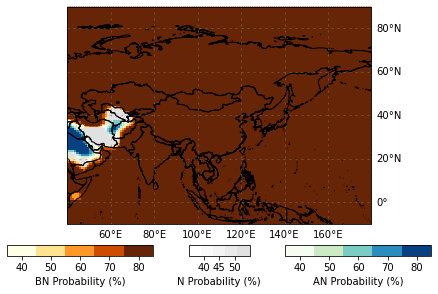

In [14]:
mc = xc.MemberCount() 
mc.fit(X_TRAIN.prec, Y.prate, x_sample_dim='S', verbose=True)
mc_preds = mc.predict(X_TEST.prec, x_sample_dim='S', verbose=True)
prob_map = xc.gaussian_smooth(mc_preds, x_sample_dim='S', x_feature_dim='C')
xc.view_probabilistic(prob_map, x_sample_dim='S', x_feature_dim='C', sample_ndx=-1)

### 2. Standardized Member Count
This method compares independently standardized model data to standardized observation data, and applies member count. It should look a little better. 

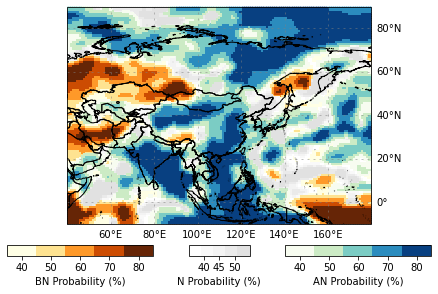

In [3]:
bcmc = xc.StandardMemberCount() 
bcmc.fit(X_TRAIN.prec, Y.prate, x_sample_dim='S', verbose=True)
bcmc_preds = bcmc.predict(X_TEST.prec, x_sample_dim='S', verbose=True)
prob_map = xc.gaussian_smooth(bcmc_preds, x_sample_dim='S', x_feature_dim='C')
xc.view_probabilistic(prob_map, x_sample_dim='S', x_feature_dim='C', sample_ndx=-1)

### 3. Extended Logistic Regression 
This method fits one Logistic Regression model per predictor. For each predictor, the input data is duplicated, and then the below normal threshold is added as a predictor to the first half , and the above normal threshold added as a predictor to the second half. The Target data is also doubled, and the first half converted to "exceeded below normal threshold / not"  and the second half converted to "exceeded above normal threshold / not". The models are then trained. 

To produce predictions, the same input data transformation is applied. For each trained LR, predictions are made. The second half of the predictions are taken to be P(AN), and the first half of the predictions are taken to be 1 - P(BN). 
The Normal category is computed by 

$P(NN) = 1 - P(AN) - P(BN)$ 

The mean of each tercile probability is taken across all of the trained LRs. 

Fitting MultipleELR: 2021-08-06 19:15:40.289125 [*************************]
Predicting MultipleELR: 2021-08-06 19:15:52.790309 [*************************]


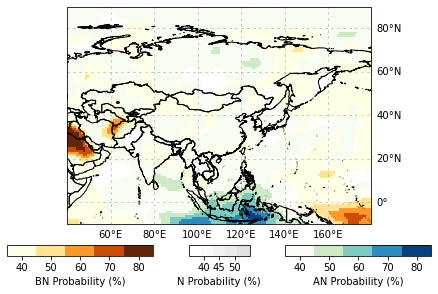

In [4]:
elr = xc.ExtendedLogisticRegression() 
elr.fit(X_TRAIN.prec, Y.prate, x_sample_dim='S', verbose=True)
elr_preds = elr.predict(X_TEST.prec, x_sample_dim='S', verbose=True)
prob_map = xc.gaussian_smooth(elr_preds, x_sample_dim='S', x_feature_dim='C')
xc.view_probabilistic(prob_map, x_sample_dim='S', x_feature_dim='C', sample_ndx=-1)

### 4. Multinomial Extended Logistic Regression
This MME trains a Multinomial Logistic Regression. The input data is duplicated, and then the below normal threshold is added as a predictor to the first half , and the above normal threshold added as a predictor to the second half. The Target data is also doubled, and the first half converted to "exceeded below normal threshold / not"  and the second half converted to "exceeded above normal threshold / not". The model are then trained. 

Predictions are made by applying the same input data transformation as above, and making predictions. The first half of the predicted data is taken to be 1 - P(BN), and the second half is taken to be P(AN). P(NN) is calculated as

$P(NN) = 1 - P(AN) - P(BN)$


Fitting ELR: 2021-08-06 19:16:44.465668 [*************************]
Predicting ELR: 2021-08-06 19:16:49.467799 [*************************]


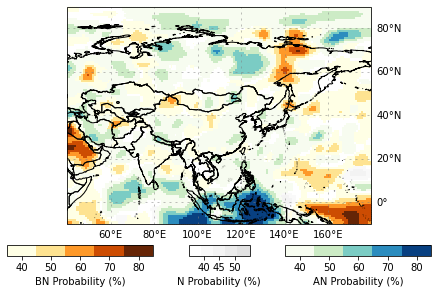

In [5]:
melr = xc.MultiExtendedLogisticRegression() 
melr.fit(X_TRAIN.prec, Y.prate, x_sample_dim='S', verbose=True)
melr_preds = melr.predict(X_TEST.prec, x_sample_dim='S', verbose=True)
prob_map = xc.gaussian_smooth(melr_preds, x_sample_dim='S', x_feature_dim='C')
xc.view_probabilistic(prob_map, x_sample_dim='S', x_feature_dim='C', sample_ndx=-1)

### 5. Probabilistic Output Extreme Learning Machine (POELM)
This model implements POELM, which involves running the input data through randomly initialized perceptrons, then solving a sigmoid objective function between the hidden layer output and the target data using linear programming. 
For outputs where the total probability is greater than 1.0, $\frac{X_i}{\sum^3_{i=0}{X_i}}$ is applied. Where it is < 1.0, SoftMax is applied. 

Fitting POELM: 2021-08-06 19:17:16.042490 [*************************]
Predicting POELM: 2021-08-06 19:17:27.806097 [*************************]


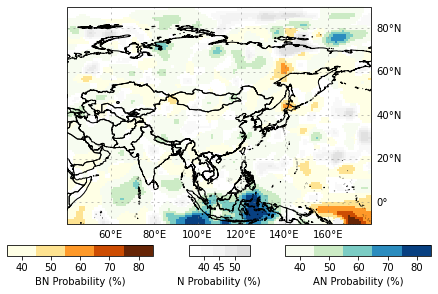

In [6]:
melm = xc.ProbabilisticELM(hidden_layer_size=50) 
melm.fit(X_TRAIN.prec, Y.prate, x_sample_dim='S', verbose=True)
melm_preds = melm.predict(X_TEST.prec, x_sample_dim='S', verbose=True)
prob_map = xc.gaussian_smooth(melm_preds, x_sample_dim='S', x_feature_dim='C')
xc.view_probabilistic(prob_map, x_sample_dim='S', x_feature_dim='C', sample_ndx=-1)

### 6. Probabilistic Output ELM with PCA (POELM-PCA)
PCA is applied before fitting the POELM Model.

Fitting POELM: 2021-08-06 19:17:45.198173 [*************************]
Predicting POELM: 2021-08-06 19:17:54.097678 [*************************]


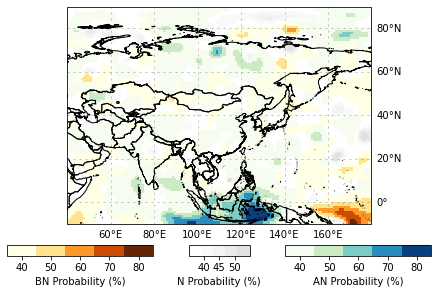

In [7]:
pmelm = xc.ProbabilisticELMPCA(hidden_layer_size=25) 
pmelm.fit(X_TRAIN.prec, Y.prate, x_sample_dim='S', verbose=True)
pmelm_preds = pmelm.predict(X_TEST.prec, x_sample_dim='S', verbose=True)
prob_map = xc.gaussian_smooth(pmelm_preds, x_sample_dim='S', x_feature_dim='C')
xc.view_probabilistic(prob_map, x_sample_dim='S', x_feature_dim='C', sample_ndx=-1)

### 7. Extended Probabilistic ELM 
This model implements the input doubling / threshold adding of ELR, but uses a single-output POELM to fit the data instead of Logistic Regression. 

Fitting ExtendedPOELM: 2021-08-06 19:18:21.738388 [*************************]
Predicting ExtendedPOELM: 2021-08-06 19:18:38.079462 [*************************]


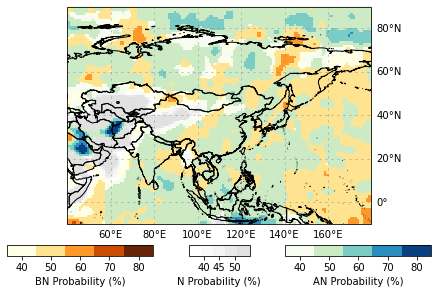

In [8]:
emelm = xc.ExtendedProbabilisticELM(hidden_layer_size=50) 
emelm.fit(X_TRAIN.prec, Y.prate, x_sample_dim='S', verbose=True)
emelm_preds = emelm.predict(X_TEST.prec, x_sample_dim='S', verbose=True)
prob_map = xc.gaussian_smooth(emelm_preds, x_sample_dim='S', x_feature_dim='C')
xc.view_probabilistic(prob_map, x_sample_dim='S', x_feature_dim='C', sample_ndx=-1)

### 8. Multinomial Naive Bayes

Fitting NaiveBayesProbabilistic: 2021-08-06 19:18:50.815938 [*************************]
Predicting NaiveBayesProbabilistic: 2021-08-06 19:18:54.252846 [*************************]


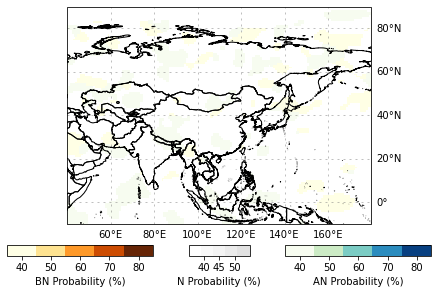

In [9]:
mnb = xc.NaiveBayes() 
mnb.fit(X_TRAIN.prec, Y.prate, x_sample_dim='S', verbose=True)
mnb_preds = mnb.predict(X_TEST.prec, x_sample_dim='S', verbose=True)
prob_map = xc.gaussian_smooth(mnb_preds, x_sample_dim='S', x_feature_dim='C')
xc.view_probabilistic(prob_map, x_sample_dim='S', x_feature_dim='C', sample_ndx=-1)

### 9. Extended Multinomial Naive Bayes
This model implements the input doubling / threshold adding of ELR, but uses a binary-output multinomial Naive Bayes model to fit the data.

Fitting ExtendedNB: 2021-08-06 19:19:11.474718 [*************************]
Predicting ExtendedNB: 2021-08-06 19:19:18.067408 [*************************]


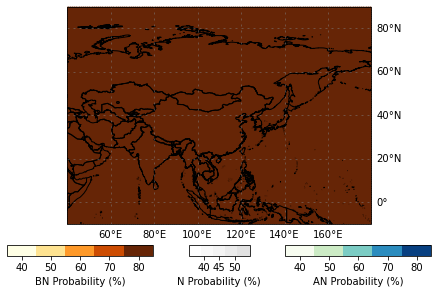

In [10]:
emnb = xc.ExtendedNaiveBayes() 
emnb.fit(X_TRAIN.prec, Y.prate, x_sample_dim='S', verbose=True)
emnb_preds = emnb.predict(X_TEST.prec, x_sample_dim='S', verbose=True)
prob_map = xc.gaussian_smooth(emnb_preds, x_sample_dim='S', x_feature_dim='C')
xc.view_probabilistic(prob_map, x_sample_dim='S', x_feature_dim='C', sample_ndx=-1)

### 10. Multi-Layer Perceptron  *** * Warning: Slow * ***

Fitting MultiLayerPerceptronProbabilistic: 2021-08-06 19:44:40.857873 [*************************]
Predicting MultiLayerPerceptronProbabilistic: 2021-08-06 19:44:47.480961 [*************************]


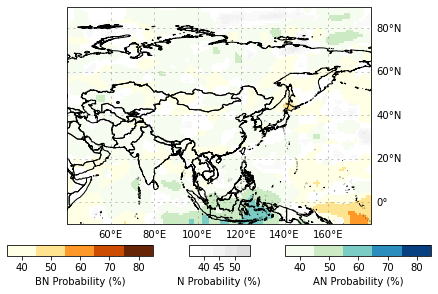

In [11]:
mlp = xc.ProbabilisticMLP(hidden_layer_sizes=(25, 10)) 
mlp.fit(X_TRAIN.prec, Y.prate, x_sample_dim='S', verbose=True)
mlp_preds = mlp.predict(X_TEST.prec, x_sample_dim='S', verbose=True)
prob_map = xc.gaussian_smooth(mlp_preds, x_sample_dim='S', x_feature_dim='C')
xc.view_probabilistic(prob_map, x_sample_dim='S', x_feature_dim='C', sample_ndx=-1)

### 11. Extended Multi-Layer Perceptron * * Warning: Slow * *
This model implements the input doubling / threshold adding of ELR, but uses a binary-output MLP model to fit the data.

Fitting ExtendedMultiLayerPerceptronProbabilistic: 2021-08-06 19:50:52.233136 [*************************]
Predicting ExtendedMultiLayerPerceptronProbabilistic: 2021-08-06 19:51:05.980275 [*************************]


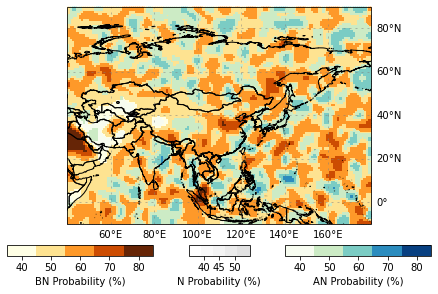

In [12]:
emlp = xc.ExtendedProbabilisticMLP(hidden_layer_sizes=(25)) 
emlp.fit(X_TRAIN.prec, Y.prate, x_sample_dim='S', verbose=True)
emlp_preds = emlp.predict(X_TEST.prec, x_sample_dim='S', verbose=True)
prob_map = xc.gaussian_smooth(emlp_preds, x_sample_dim='S', x_feature_dim='C')
xc.view_probabilistic(prob_map, x_sample_dim='S', x_feature_dim='C', sample_ndx=-1)

### 12. Random Forest   *** * Warning: Slow * ***

Fitting RandomForestProbabilistic: 2021-08-06 20:12:35.690273 [*************************]
Predicting RandomForestProbabilistic: 2021-08-06 20:12:39.229256 [*************************]


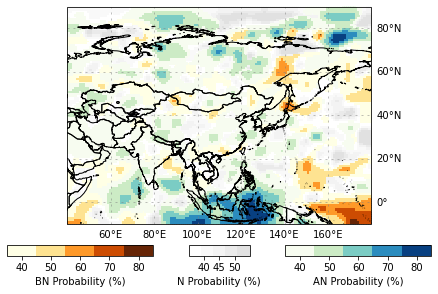

In [13]:
rf = xc.ProbabilisticRF() 
rf.fit(X_TRAIN.prec, Y.prate, x_sample_dim='S', verbose=True)
rf_preds = rf.predict(X_TEST.prec, x_sample_dim='S', verbose=True)
prob_map = xc.gaussian_smooth(rf_preds, x_sample_dim='S', x_feature_dim='C')
xc.view_probabilistic(prob_map, x_sample_dim='S', x_feature_dim='C', sample_ndx=-1)